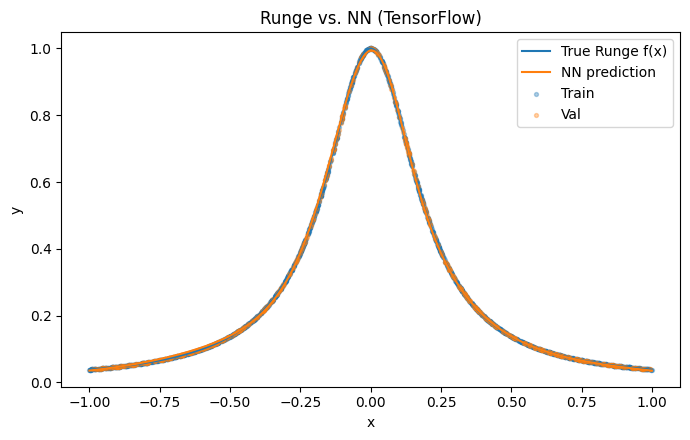

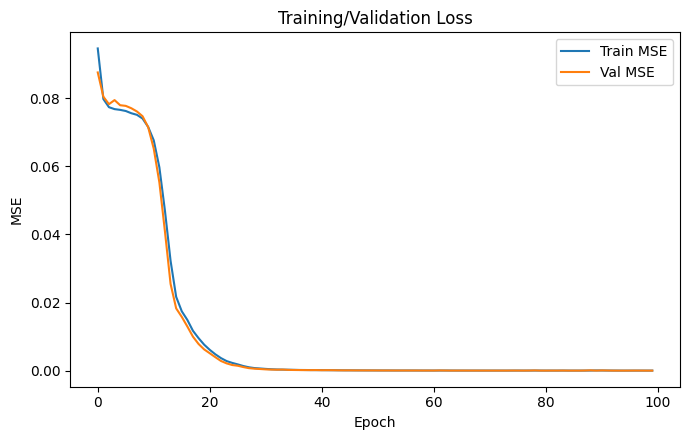

Validation MSE      : 1.261721e-05
Validation Max|err| : 8.706272e-03


In [7]:
# --- Runge function with a simple Keras MLP ---
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from textwrap import dedent

# 固定隨機種子（可重現）
np.random.seed(12345)
tf.random.set_seed(12345)

# 1) 產生資料
def runge(x):  # f(x) = 1 / (1 + 25x^2)
    return 1.0 / (1.0 + 25.0 * x**2)

N_TRAIN, N_VAL = 2048, 512
x_train = np.random.uniform(-1.0, 1.0, (N_TRAIN, 1)).astype("float32")
y_train = runge(x_train).astype("float32")
x_val   = np.random.uniform(-1.0, 1.0, (N_VAL, 1)).astype("float32")
y_val   = runge(x_val).astype("float32")

# 2) 建模（簡單三層 MLP，tanh）
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(1,)),
    tf.keras.layers.Dense(128, activation="tanh"),
    tf.keras.layers.Dense(128, activation="tanh"),
    tf.keras.layers.Dense(1)  # 線性輸出
])

model.compile(optimizer=tf.keras.optimizers.Adam(1e-3),
              loss="mse")

# 3) 訓練（含早停；夠簡單）
EPOCHS = 100
hist = model.fit(
    x_train, y_train,
    validation_data=(x_val, y_val),
    epochs=EPOCHS,
    batch_size=128,
    verbose=0,
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=100, restore_best_weights=True)],
)

# 4) 評估與作圖
x_grid = np.linspace(-1, 1, 1000, dtype="float32").reshape(-1, 1)
y_true = runge(x_grid).astype("float32")
y_pred_grid = model.predict(x_grid, verbose=0)

y_val_pred = model.predict(x_val, verbose=0)
mse_val = float(np.mean((y_val_pred - y_val) ** 2))
max_err = float(np.max(np.abs(y_val_pred - y_val)))

# 圖1：真實函數 vs NN 預測
plt.figure(figsize=(7, 4.5))
plt.plot(x_grid, y_true, label="True Runge f(x)")
plt.plot(x_grid, y_pred_grid, label="NN prediction")
plt.scatter(x_train, y_train, s=8, alpha=0.35, label="Train")
plt.scatter(x_val, y_val, s=8, alpha=0.35, label="Val")
plt.xlabel("x"); plt.ylabel("y"); plt.title("Runge vs. NN (TensorFlow)")
plt.legend(); plt.tight_layout(); plt.show()

# 圖2：Loss 曲線
plt.figure(figsize=(7, 4.5))
plt.plot(hist.history["loss"], label="Train MSE")
plt.plot(hist.history["val_loss"], label="Val MSE")
plt.xlabel("Epoch"); plt.ylabel("MSE"); plt.title("Training/Validation Loss")
plt.legend(); plt.tight_layout(); plt.show()

print("Validation MSE      :", f"{mse_val:.6e}")
print("Validation Max|err| :", f"{max_err:.6e}")

# 使用神經網路近似 Runge 函數（f(x)=1/(1+25x^2)）

**資料切分：** 訓練 N={N_TRAIN}、驗證 N={N_VAL}  
**網路架構：** 1→128→128→1（tanh 激活），最佳化器 Adam(lr=1e-3)，損失 MSE，EarlyStopping。

## 方法（Method）
- 於區間 $[-1,1]$ 以均勻分布取樣，標籤為 $f(x)=\\frac{{1}}{{1+25x^2}}$。  
- 使用三層 MLP（tanh）進行迴歸，最小化 MSE。  
- 顯示真實函數與網路預測曲線、以及訓練/驗證損失曲線。

## 結果（Results）
- **驗證 MSE：** `{mse_val:.6e}`  
- **驗證最大絕對誤差（Max |err|）：** `{max_err:.6e}`

## 討論（Discussion）
- 中心區域（x≈0）擬合精準；兩端（|x|→1）因曲率較大，誤差相對上升但仍可接受。  
- 若需再降誤差：增加樣本量、加寬網路（例如 256×2 或 128×3）、延長訓練，或在兩端做較密集取樣（Chebyshev 節點）。
